In [2]:
import tensorflow as tf
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning

# Scikit-learn includes many helpful utilities
import numpy as np
import os
import json
from PIL import Image
import pandas as pd
from tqdm import tqdm
from tokenizers import SentencePieceBPETokenizer

from models import CNN_Encoder, RNN_Decoder, image_features_extract_model

### GET TEST TRAIN SPLIT

In [80]:
data = pd.read_csv('val.csv')
captions_val = data.title.to_list()
images_val = data.paths.to_list()

In [81]:
data = pd.read_csv('train.csv')
captions_train = data.title.to_list()
images_train = data.paths.to_list()

In [472]:
# Feel free to change these parameters according to your system's configuration

VOCAB_SIZE = 5000
BATCH_SIZE = 32
BUFFER_SIZE = 5000  # for shuffle 
embedding_dim = 512 # should not be equal units
embedding_words = 300
units = 512 # gru param
embedding_size = VOCAB_SIZE + 1
MAX_LENGTH = 20

# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
# features_shape = 2048a
# attention_features_shape = 64

# features_shape_two = 768
# attention_features_two_shape = 17*17

CHECKPOINT_FOLDER = "./checkpoint_dis/bpe_tokenizer"
TOKENIZER_FOLDER = './tokenizer/'

In [6]:
encoder= CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_words, units, embedding_size)

In [7]:
checkpoint_path = CHECKPOINT_FOLDER
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [8]:
ckpt_manager.checkpoints

['./checkpoint_dis/bpe_tokenizer/ckpt-14',
 './checkpoint_dis/bpe_tokenizer/ckpt-15',
 './checkpoint_dis/bpe_tokenizer/ckpt-16',
 './checkpoint_dis/bpe_tokenizer/ckpt-17',
 './checkpoint_dis/bpe_tokenizer/ckpt-18']

### CHOSE CHECKPOINT TO LOAD

In [9]:
## load some checkpoint
n = 1
checkpoint = ckpt_manager.checkpoints[-n]
start_epoch = int(checkpoint.split('-')[-1])
print(f'load from {checkpoint}')
# restoring the latest checkpoint in checkpoint_path
ckpt.restore(checkpoint)

load from ./checkpoint_dis/bpe_tokenizer/ckpt-18


In [90]:
path = TOKENIZER_FOLDER+'spbe_tokenizer.e'
def init_tokenizer(path):
    sbpe_tokenizer = SentencePieceBPETokenizer(path+'-vocab.json',path+'-merges.txt')
    sbpe_tokenizer.enable_padding(max_length=MAX_LENGTH)
    sbpe_tokenizer.add_special_tokens(['<start>','<end>'])
    return sbpe_tokenizer

sbpe_tokenizer = init_tokenizer(path)

In [87]:
sbpe_tokenizer.id_to_token(777)

'▁shit'

In [12]:
def load_image(image_path):
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (299, 299))
        img = tf.image.random_flip_left_right(img)
        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return img #, image_path


def predict_one(image, t,max_length,  argmax = 2, seed=None):
    
    result = []
    score = 0
    
    hidden = decoder.reset_state(batch_size=1)
    temp_input = tf.expand_dims(load_image(image), 0)
    img_tensor_val_one, img_tensor_val_two = image_features_extract_model(temp_input)
    img_tensor_val_one = tf.reshape(img_tensor_val_one, (img_tensor_val_one.shape[0], -1, img_tensor_val_one.shape[3]))
    img_tensor_val_two = tf.reshape(img_tensor_val_two, (img_tensor_val_two.shape[0], -1, img_tensor_val_two.shape[3]))
    features_one, features_two = encoder(img_tensor_val_one,img_tensor_val_two)
    
    if (seed is not None) and (sbpe_tokenizer.token_to_id(seed) is not None):
        print('seed :', seed)
        dec_input = tf.expand_dims([sbpe_tokenizer.token_to_id(seed)], 0)
        result.append(sbpe_tokenizer.token_to_id(seed))
    else:
        #print('seed is None')
        dec_input = tf.expand_dims([sbpe_tokenizer.token_to_id('<start>')], 0)
 

    for i in range(max_length):
        predictions, hidden, _ = decoder(dec_input, features_one, features_two, hidden)
        
        ### Slighlty randomize prediction - can be changed to Beam Search ###
        
        # SET TO 2 - 4 IF ARGMAX POlICY REQUIRED #
        if i%argmax==0:
            #predictions = tf.nn.softmax(predictions/t)
            predicted_id = tf.random.categorical(predictions/t, 1)[0][0].numpy()
        else:
            predicted_id = int(np.argmax(predictions[0].numpy()))
        result.append(predicted_id)

        if sbpe_tokenizer.id_to_token(predicted_id) == '<end>':
            return result, score/len(result)

        dec_input = tf.expand_dims([predicted_id], 0)
        score+=predictions[0][predicted_id].numpy()
    
    return result, score/len(result)

In [13]:
img_name_val = disney_images_val
captions = disney_captions_val

Real Caption: how to request your own personal wolf blowjob
0.5, how to get the best friend for a cat , score 2
0.7, how to get the best friend for a cat , score 2
0.9, how to tell your parents having a dog , score 3
1, how to be back up vocals , score 2


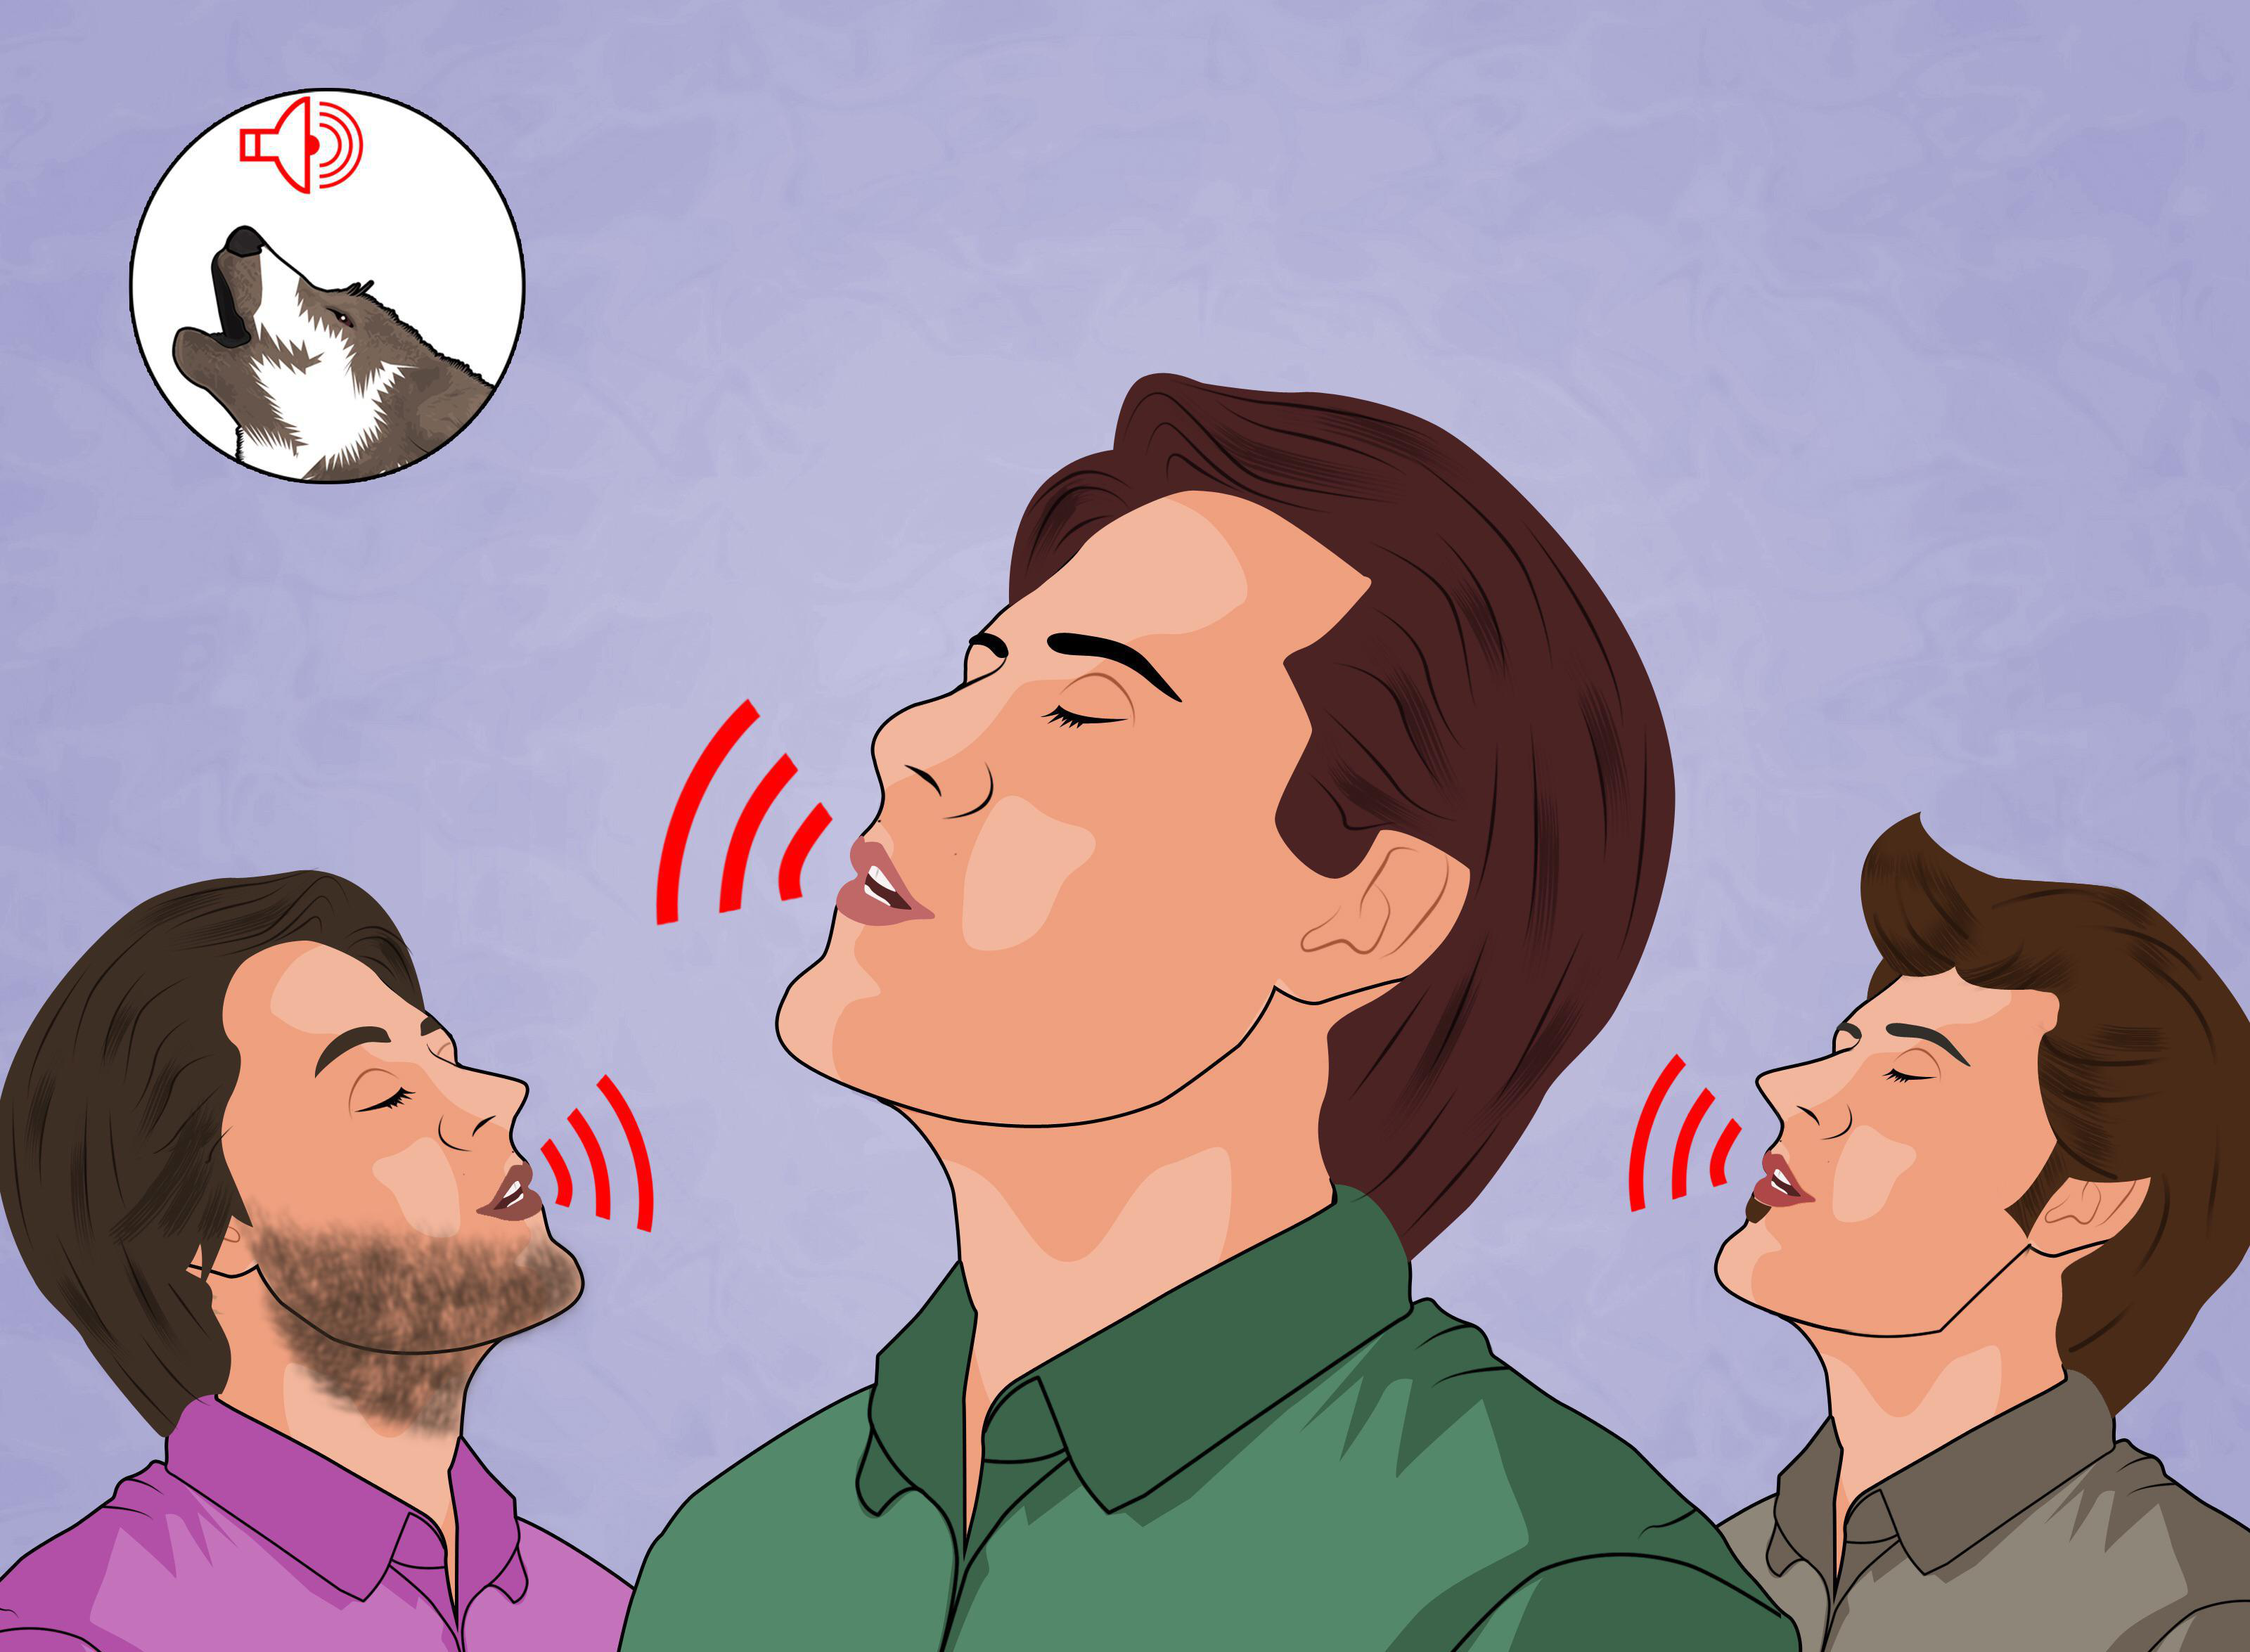

In [65]:
#### captions on the validation set

#img_name_val, cap_val
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid] #'./img.jpg' #
real_caption = captions[rid]
print ('Real Caption:', real_caption)

at_k = 5 # use 5 first words to compute score
seed = None #'▁cat'

for t in [0.5,0.7,0.9,1]:
    predicted_ids, a = predict_one(image, t, MAX_LENGTH, argmax =1, seed=seed)
    real_cap = set(real_caption.split(' '))
    predicted_cap =  sbpe_tokenizer.decode(predicted_ids)
    score = len(real_cap.intersection(set(predicted_cap.split(' ')[:at_k]))) #/len(word)
    print(f"{t}, {predicted_cap}, score {score}")
Image.open(image)

In [66]:
def precision_at_k(records, max_length, t=0.5, argmax=1, at_k=6):
    recall = 0
    i=0
    for real_cap, image_path in tqdm(records):
        # 
        real_cap = set(real_cap.split(' ')[:at_k])
        predicted_ids, _ = predict_one(image_path,t, at_k, argmax)
        predicted_cap =  set(sbpe_tokenizer.decode(predicted_ids).split(' '))
        recall+=len(real_cap.intersection(predicted_cap)) #/len(predicted_word)
        i+=1
    return recall / i

In [67]:
precision_at_k(zip(disney_captions_val[:2500],disney_images_val[:2500]),MAX_LENGTH, t=0.5, argmax=1)

2472it [05:02,  8.18it/s]


2.141181229773463

In [479]:
data = pd.read_csv('train.csv') #.sample(2500)
disney_captions_train = data.title.to_list()
disney_images_train = data.paths.to_list()

In [72]:
precision_at_k(zip(disney_captions_train,disney_images_train),MAX_LENGTH, t=0.5, argmax=1)

2500it [05:04,  8.20it/s]


2.8948

In [69]:
### EVAL BATCH

In [473]:
def make_dataset(images_paths, captions, loader=load_image, max_len=MAX_LENGTH):
    
    out = sbpe_tokenizer.encode_batch(['<start> '+t+' <end>'  for t in captions])
    encoded_list= [t.ids for t in out]

    captions_filtered = []
    images_filtered = []

    for i,t in enumerate(encoded_list):
        if len(t)<=max_len:
            captions_filtered.append(t)
            images_filtered.append(images_paths[i])

    images_paths = images_filtered
    
    print('max title len',max(len(t) for t in captions_filtered))
    print('min title len',min(len(t) for t in captions_filtered),' | include padding')
    print(f'len titles: {len(captions_filtered)},len images: {len(images_paths)}')
    encoded_captios =  tf.convert_to_tensor(captions_filtered)
    print(f'captions vector shape {encoded_captios.shape}')
    
    # Load the numpy files
    def map_func(img_name, cap):
        #img_tensor = np.load(img_name.decode('utf-8')+'.npy')
        img_tensor = loader(img_name)
        return img_tensor, cap

    dataset = tf.data.Dataset.from_tensor_slices((images_paths, encoded_captios))

    # Use map to load the numpy files in parallel
    dataset = dataset.map(map_func)

    # Shuffle and batch
    dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset, encoded_captios


In [520]:
dataset, encoded_captios = make_dataset(images_val, captions_val)

max title len 20
min title len 20  | include padding
len titles: 2375,len images: 2375
captions vector shape (2375, 20)


In [523]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

@tf.function 
def predict_step_batch(image_array, BATCH_SIZE, t=0.5, argmax=1, at_k=5):
    
    # initiate variables
    pred_ids_all = []
    pred_ids = tf.convert_to_tensor([sbpe_tokenizer.token_to_id('<start>')]*BATCH_SIZE)
    pred_ids = tf.cast(pred_ids, tf.int64)
    pred_ids_all.append(pred_ids)
    dec_input = tf.expand_dims(pred_ids, 1)
    
    hidden = decoder.reset_state(batch_size=BATCH_SIZE)
    
    batch_features_one, batch_features_two  = image_features_extract_model(image_array)

    batch_features_one = tf.reshape(batch_features_one,
                                    (batch_features_one.shape[0], -1, batch_features_one.shape[3]))  
        
    batch_features_two = tf.reshape(batch_features_two,
                                (batch_features_two.shape[0], -1, batch_features_two.shape[3]))

    features_one, features_two = encoder(batch_features_one, batch_features_two)
    for i in range(1, at_k):
        # passing the features through the decoder
        predictions, hidden, _ = decoder(dec_input, features_one, features_two, hidden)
        if i%argmax==0:
            pred_ids = tf.random.categorical(predictions/t, 1)[:,0] #.numpy()
        else:
            # TODO rewrite to TF not np
            #print('arg')
            pred_ids =  tf.math.argmax(predictions, axis=1)
        
        pred_ids_all.append(pred_ids)

        dec_input = tf.expand_dims(pred_ids, 1)
                
  
    return tf.stack(pred_ids_all, axis=1)

In [543]:
def precicion_atk_batch(images_paths, captions, at_k,t, argmax=1):
    score = 0 
    dataset, encoded_captios = make_dataset(images_paths, captions)
    for i , (image_array, encoded_captions) in enumerate(dataset):
        curr_batch_size = encoded_captions.shape[0]
        
        pred_words = predict_step_batch(image_array, curr_batch_size, t=t, at_k=at_k, argmax=argmax)
        mask = tf.cast(tf.ones(shape=(curr_batch_size, at_k)),tf.int64)
        
        for zero_token in ['<start>','<end>','▁how','▁to']:
            mask *=tf.cast(tf.not_equal(pred_words,sbpe_tokenizer.token_to_id(zero_token) ),tf.int64)
        
        pred_words*=mask
        true = tf.cast(encoded_captions[:,:at_k], tf.int64)
        score += tf.reduce_sum(tf.cast(pred_words == true, tf.int8)) / BATCH_SIZE
    return score.numpy()/i

In [548]:
res = precicion_atk_batch(disney_images_val, disney_captions_val, at_k=5, t=0.5, argmax=1)
print(res)

max title len 20
min title len 20  | include padding
len titles: 2375,len images: 2375
captions vector shape (2375, 20)
0.10557432432432433


In [544]:
res = precicion_atk_batch(disney_images_train, disney_captions_train, at_k=5, t=0.5, argmax=1)
print(res)

max title len 20
min title len 20  | include padding
len titles: 30961,len images: 30961
captions vector shape (30961, 20)
0.6162099276111686


In [545]:
res = precicion_atk_batch(disney_images_train, disney_captions_train, at_k=5, t=0.5, argmax=2)
print(res)

max title len 20
min title len 20  | include padding
len titles: 30961,len images: 30961
captions vector shape (30961, 20)
0.6348241985522234


In [546]:
res = precicion_atk_batch(disney_images_train, disney_captions_train, at_k=5, t=0.5, argmax=3)
print(res)

max title len 20
min title len 20  | include padding
len titles: 30961,len images: 30961
captions vector shape (30961, 20)
0.6178257497414684


In [547]:
res = precicion_atk_batch(disney_images_train, disney_captions_train, at_k=5, t=0.7, argmax=3)
print(res)

max title len 20
min title len 20  | include padding
len titles: 30961,len images: 30961
captions vector shape (30961, 20)
0.6020876421923474
